In [142]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm
import json
import shap
import pandas as pd


In [143]:
pretrained_model = keras_cv.models.ResNetV2Backbone.from_preset(
    "resnet50_v2_imagenet"
)


In [144]:
notebook_path = os.path.abspath("selvtrent.ipynb")

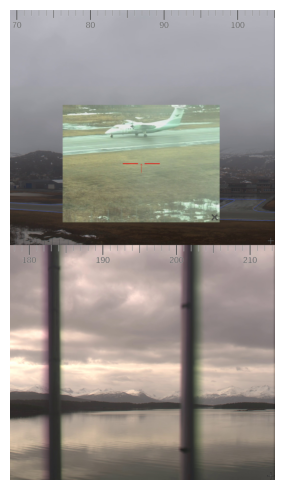

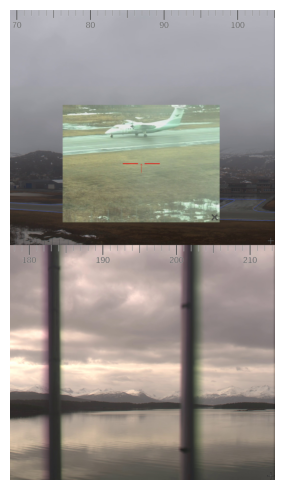

In [145]:
filepath = os.path.join(os.path.dirname(notebook_path), "frames/116.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)


In [146]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)


In [147]:
image_batch = inference_resizing([image])


In [148]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_ids = [v[1] for v in json.load(file).values()]
    
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [149]:
y_pred = pretrained_model.predict(image_batch)

print(y_pred)

predictions = []

# Iterate over the predictions
for image_pred in y_pred[0]:  # Assuming y_pred contains only one batch
    for box_pred in image_pred:
        # Flatten the bounding box prediction
        flattened_pred = box_pred.flatten()
        predictions.append(flattened_pred)

# Create a DataFrame from the predictions
df = pd.DataFrame(predictions)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    df=df,  # Pass the DataFrame instead of y_pred
    scale=5,
    font_scale=0.7,
    bounding_box_format="xyxy",  # Assuming you've converted the bounding box format
    class_mapping=class_mapping,
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[[[[0.         0.         0.88964677 ... 0.         0.58508945
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.00785875 0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 1.2982657  0.
    4.2799587 ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.02840686]
   [0.         0.         0.         ... 0.70408404 0.
    1.5004985 ]]

  [[0.         0.         0.         ... 0.         0.
    0.        ]
   [0.       

ValueError: 6 columns passed, passed data had 2048 columns

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


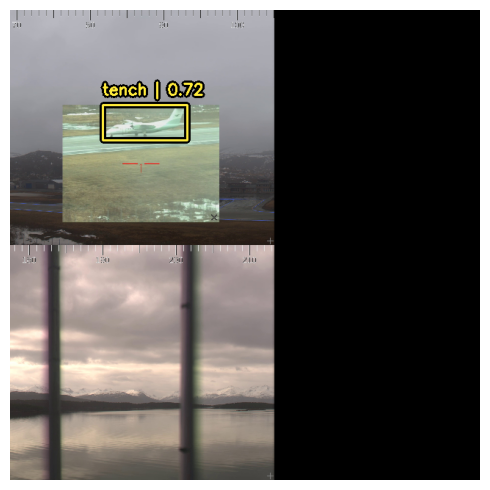

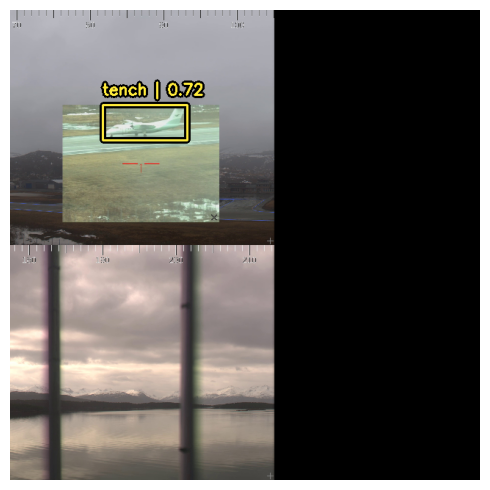

In [ ]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.ResNetV2Backbone.from_preset(
    "resnet50_v2_imagenet",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
